<a href="https://colab.research.google.com/github/gombergere/arthomas/blob/master/TFObjDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Demonstration de la fonction object detection' de Tensorflow
# https://towardsdatascience.com/understanding-object-detection-9ba089154df8
# Lien du Github 
# https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
# Beaucoup de choses intéressantes
# Comment installer tensorflow 2.0
# Il y a beaucoup d'instructions bien mystérieuses
# Voir comment on charge un modele pre-existant

In [67]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.1.0rc2)


In [68]:
!pip install pycocotools

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [71]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017523 sha256=db7831c00f1e615b7ea4b46d0058787062ec9b327a93c62e38c6af7e8b08bf68
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsw8mc2b/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']
  return model

In [0]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [76]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

In [0]:
mkdir models/research/object_detection

In [78]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [28]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [79]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [0]:
# Ici c'est le moteur de base de la reconaissance d'objet
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

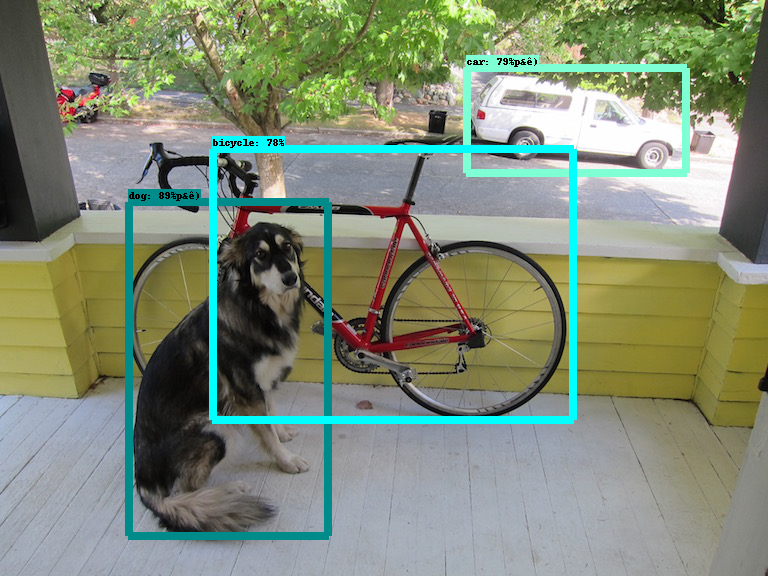

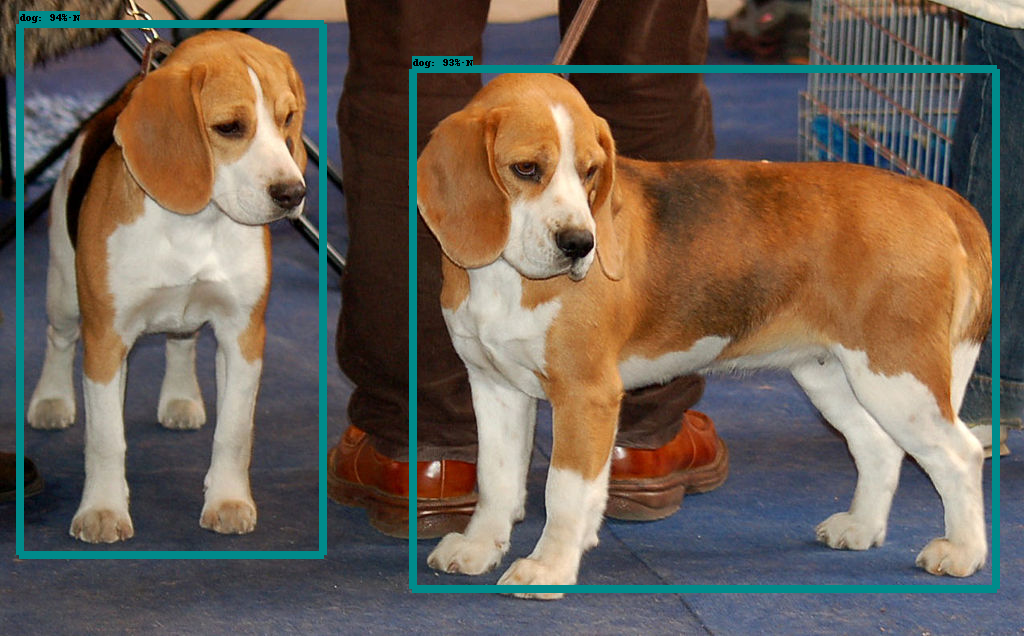

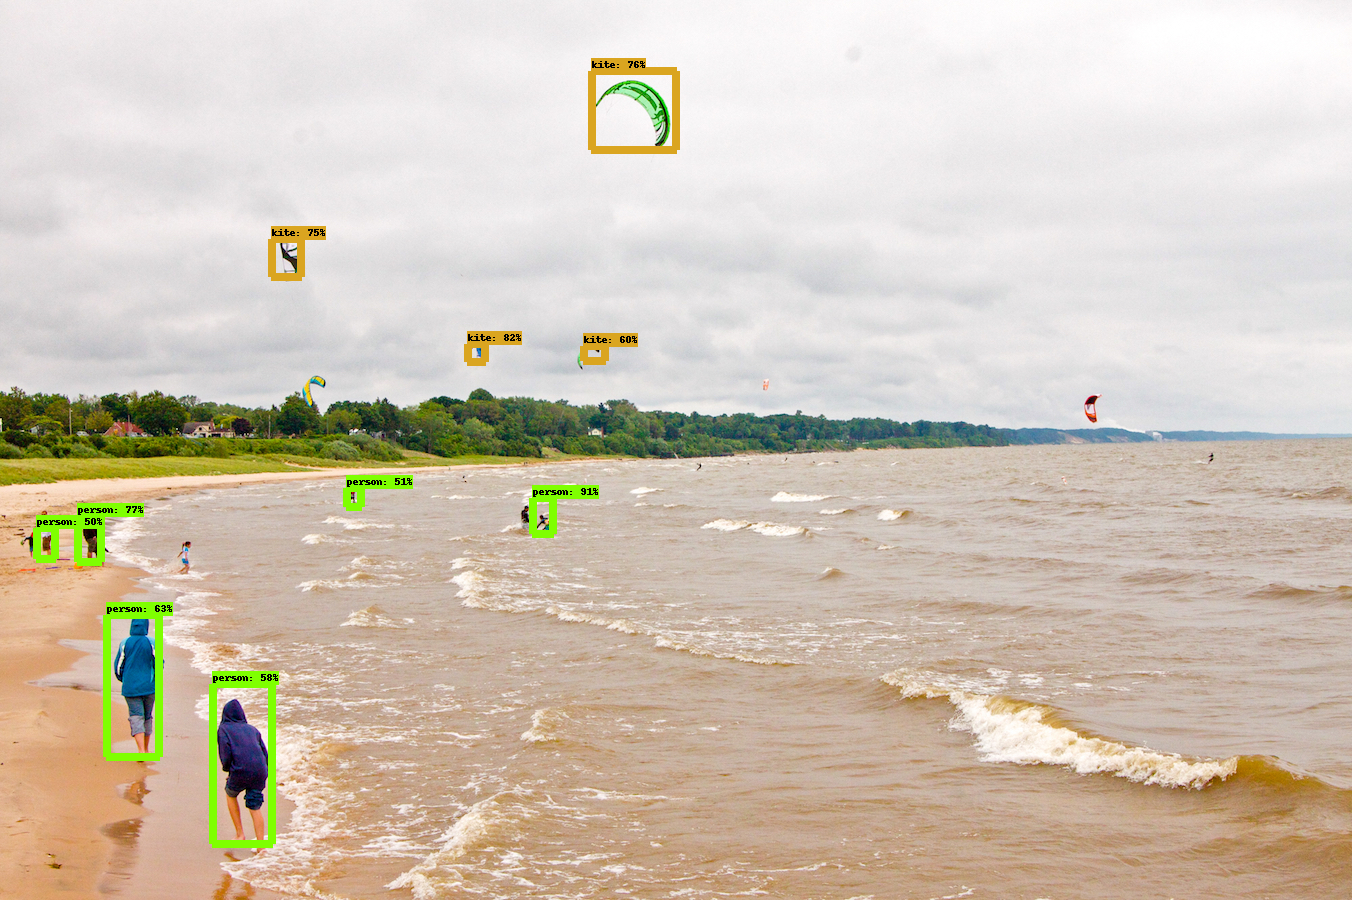

In [81]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

In [82]:
# A partir de là on utilise un modele RCCN cad avec masquage
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [83]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

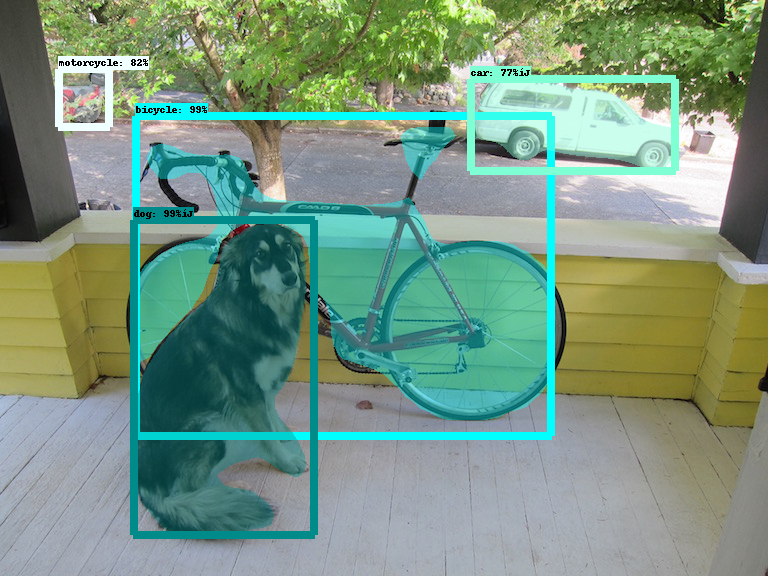

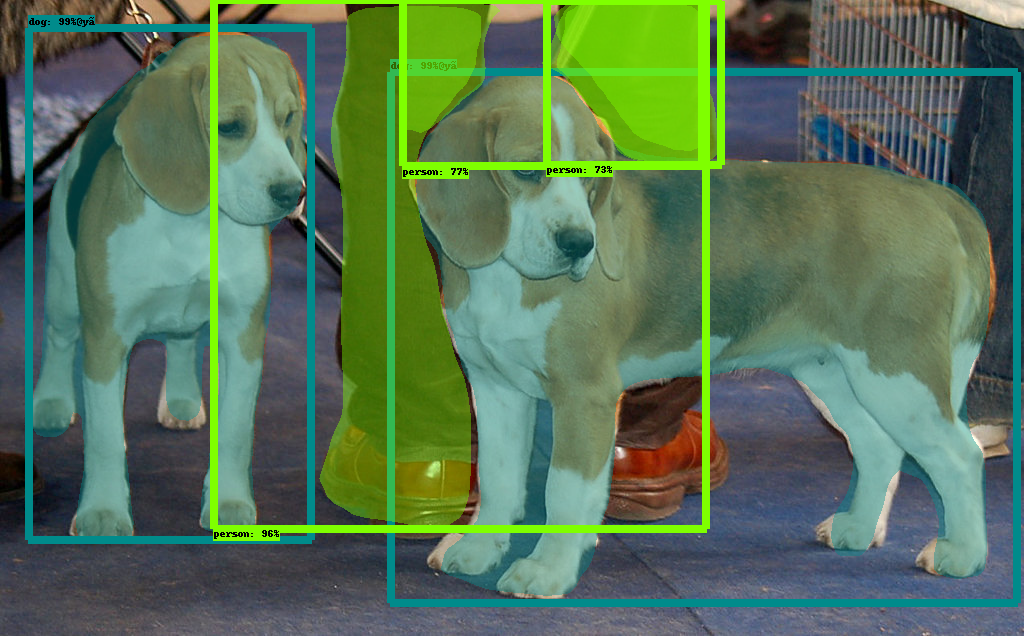

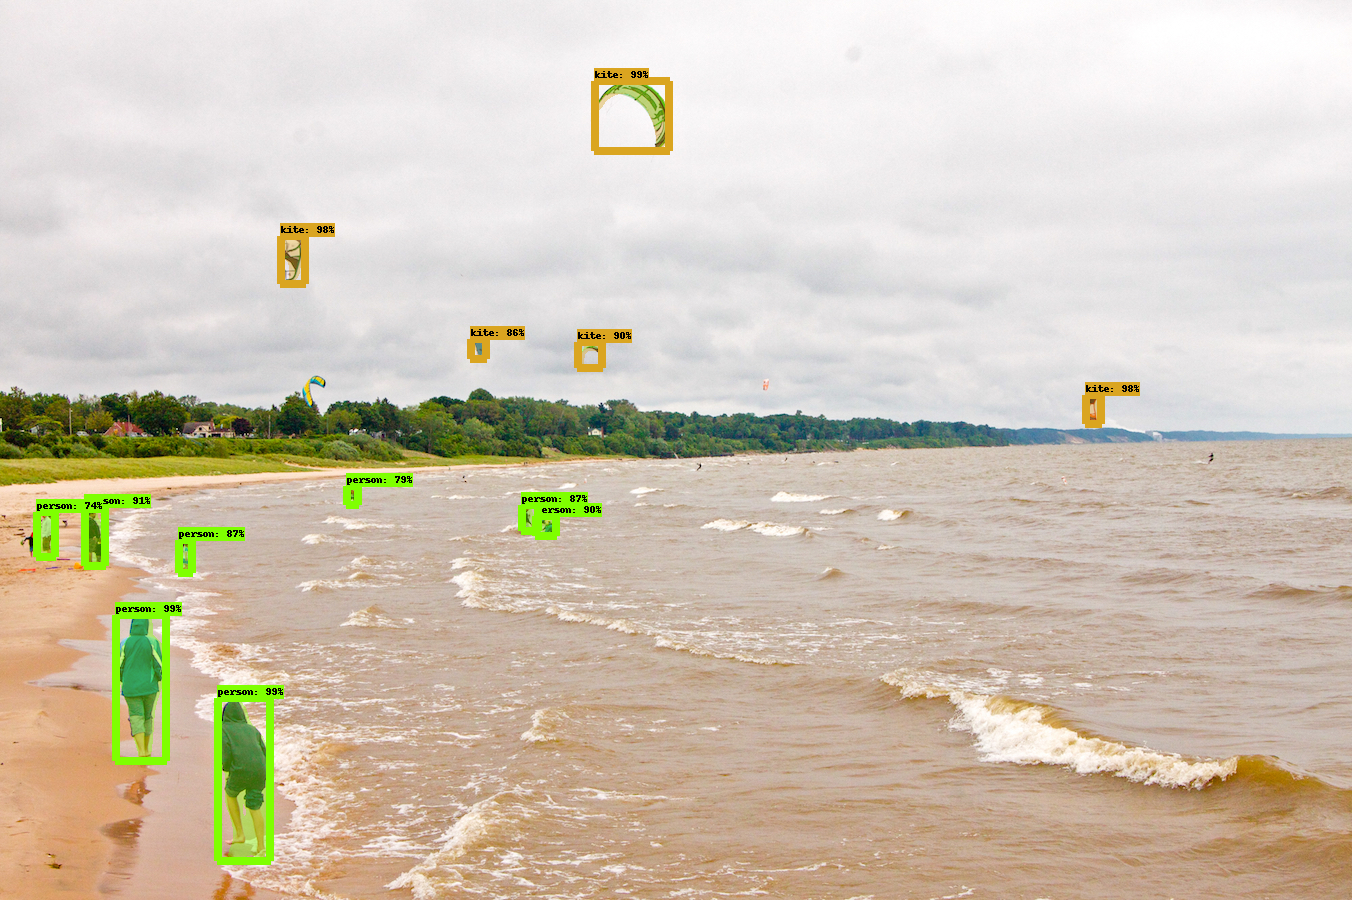

In [84]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)

In [44]:
%cd '/content/models/research/object_detection/test_images'
!pwd


/content/models/research/object_detection/test_images
/content/models/research/object_detection/test_images


In [47]:
from google.colab import files
file =files.upload()

Saving before.png to before.png
Saving bicycle.jpg to bicycle.jpg


In [48]:
!ls -l

total 2124
-rw-r--r-- 1 root root  455166 Jan  6 15:57 before.png
-rw-r--r-- 1 root root  163759 Jan  6 15:57 bicycle.jpg
-rw-r--r-- 1 root root  129862 Jan  6 14:10 image1.jpg
-rw-r--r-- 1 root root 1415684 Jan  6 14:10 image2.jpg
-rw-r--r-- 1 root root     230 Jan  6 14:10 image_info.txt
